<a href="https://colab.research.google.com/github/dowrave/Kaggle_Competition/blob/main/Kaggle_GAN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# from google.colab import files
# uploaded = files.upload()

# !mkdir -p ~/.kaggle/
# !mv kaggle.json ~/.kaggle
# !chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## 데이터 준비

https://www.kaggle.com/competitions/gan-getting-started

In [ ]:
# !kaggle competitions download -c gan-getting-started
# !unzip '*.zip'

gan-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  gan-getting-started.zip
replace monet_jpg/000c1e3bff.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import tensorflow as tf 
# TPU를 쓰는 방법이 따로 있는건가? 학습이 너무 느려서 추가해 봄
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()

print(strategy.num_replicas_in_sync)

Device: grpc://10.88.166.2:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.88.166.2:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.88.166.2:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


8


### TPU를 켜면 데이터를 조금 다르게 사용해야 함


In [ ]:
import pathlib
paint_dir = pathlib.Path('./monet_jpg/')
image_count = len(list(paint_dir.glob('*.jpg')))
print(image_count)

300


In [ ]:
photo_dir = pathlib.Path('./photo_jpg/')
photo_count = len(list(photo_dir.glob('*.jpg')))

#### Pathlib
- 파이썬 3.4부터 추가된 모듈
- Path 메서드를 통해 Path 객체를 생성할 수 있다. 이 객체를 조작하는 게 핵심.
  - `Path.glob` : 경로 내의 파일을 얻을 수 있음
    - `glob('*')` : 모든 폴더 & 파일
    - `glob('**/*')` : 모든 폴더 & 파일 (하위 폴더의 파일까지)

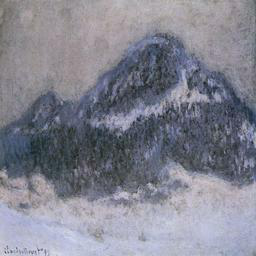

In [ ]:
import PIL
paint = list(paint_dir.glob('*.jpg'))
photo = list(photo_dir.glob('*.jpg'))
PIL.Image.open(paint[0]) # str(paint[0])이 아니어도 잘 작동한다.

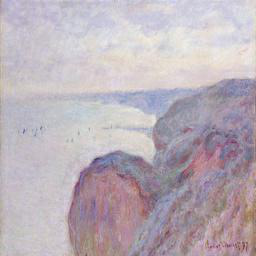

In [ ]:
PIL.Image.open(paint[1])

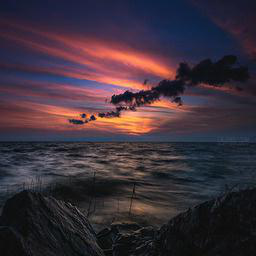

In [ ]:
PIL.Image.open(photo[0])

### 데이터 로드하기 1.
`tf.keras.preprocessing.image_dataset_from_directory`를 이용한다.
- `[-1, 1]` 전처리를 위해선 데이터셋에 넣기 전에 표준화를 적용해야 함
- 이슈 : TPU를 켜니까 데이터를 못 읽어옴;;

In [ ]:
# image_dataset

In [ ]:
# 데이터세트 만들기 : 일부 파라미터 정의
## 참고 : 이 Competition의 데이터셋은 256 * 256 으로 이미 정의되어 있긴 함
import tensorflow as tf

batch_size = 32
img_height = 256
img_width = 256

#### tf.keras.preprocessing.image_dataset_from_directory 사용 시 유의점
- 데이터셋을 만들 때 label을 부여하려 하는데, <b>기본적으로</b> 어떤 하위 폴더에 들어있느냐에 따라 label이 달라진다.
- 파라미터 `label=None`으로 하지 않으면 지정한 경로 바로 밑의 이미지는 `.jpg` 확장자 명을 가지더라도 찾지 못한다.
- 분류가 필요없는 경우는 `label=None`으로 지정해주자.
- 한 30분 헤멤 ㅎㅎ!

In [ ]:
# labels = None이 있어야 지정한 경로 바로 밑에 있는 이미지들을 탐색하며
  # 디폴트값이면 경로 밑의 subfolder를 필요로 함. 각 폴더마다 labeling을 하기 때문임(subfolder가 없으면 이미지 탐색 X)
  # Path 객체를 집어넣어도 경로명 넣은 것처럼 작동한다.

# 이거 찾는 데 30분 걸림. 오류 탐색엔 역시 라이브러리 폴더가 갑이다.
paint_ds = tf.keras.preprocessing.image_dataset_from_directory(
    paint_dir,
    labels = None,
    seed = 0,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

photo_ds = tf.keras.preprocessing.image_dataset_from_directory(
    photo_dir,
    labels = None,
    seed = 0,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


In [ ]:
# 스택오버플로우 - 무지성 코드 추가
checkpoint = tf.train.Checkpoint(model=model)
local_device_option = tf.train.CheckpointOptions(experimental_io_device="/job:localhost")
checkpoint.write(checkpoint_path, options=local_device_option)

NameError: ignored

UnimplementedError: ignored

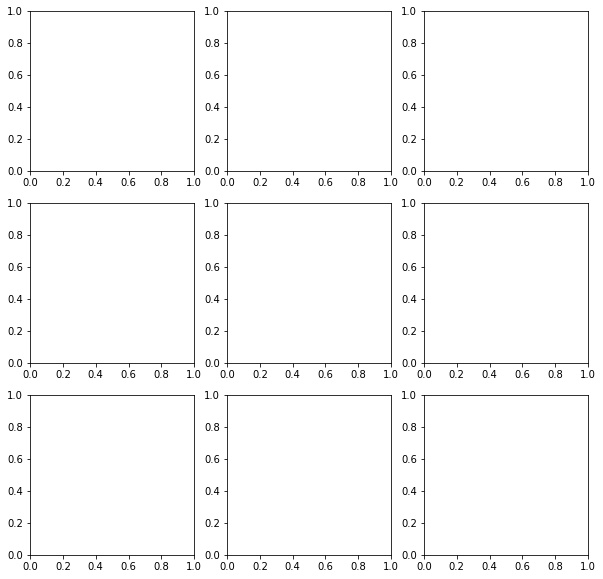

In [ ]:
# 데이터 시각화
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(3, 3, figsize=(10, 10))
for img_batch in paint_ds: # paint_ds.take()를 사용하지 않는다 : label이 1개여서?
  # print(img_batch.shape)
  for i in range(3):
    for j in range(3):
      ax[i, j].imshow(img_batch[3*i + j].numpy().astype('uint8'))
      ax[i, j].axis('off')

### 생성된 데이터셋에 함수를 적용할 수 있다 : `dataset.map()`

In [ ]:
# paint_ds = paint_ds.map(lambda x: x / 127.5 - 1)
# photo_ds = photo_ds.map(lambda x: x / 127.5 - 1)

# paint_ds = paint_ds.prefetch(tf.data.experimental.AUTOTUNE)
# photo_ds = photo_ds.prefetch(tf.data.experimental.AUTOTUNE)

## 데이터 로드하기 2
- tfrec 폴더를 이용하는 방법이다. 
- tfrec는 TFRecordDataset에 집어넣을 수 있는 것 같다
- 이번 프로젝트에서는 위의 것을 이용하기로 함
  - 왜냐하면 tfrec는 준비된 데이터셋이기 때문임
  - 데이터를 직접 모아서 진행할 경우까지 생각해보면 그냥 1로 진행하는 게 나을 것 같음

In [ ]:
# batch_size = 32
# img_height = 256
# img_width = 256

# PAINT_FILENAMES = tf.io.gfile.glob('monet_tfrec/*.tfrec')
# PHOTO_FILENAMES = tf.io.gfile.glob('photo_tfrec/*.tfrec')
# len(PAINT_FILENAMES), len(PHOTO_FILENAMES)

(5, 20)

In [ ]:
# image_size = [256, 256]

# def decode_image(image):
#   image = tf.image.decode_jpeg(image, channels = 3)
#   image = (tf.cast(image, tf.float32) / 127.5) - 1
#   image = tf.reshape(image, [*image_size, 3])
#   return image

# def read_tfrecord(example):
#   tfrecord_format = {
#       "image_name" : tf.io.FixedLenFeature([], tf.string),
#       "image" : tf.io.FixedLenFeature([], tf.string),
#       "target" : tf.io.FixedLenFeature([], tf.string)
#   }
#   example = tf.io.parse_single_example(example, tfrecord_format)
#   image = decode_image(example['image'])
#   return image

In [ ]:
# def load_dataset(filenames, labeled = True, ordered = False):
#   dataset = tf.data.TFRecordDataset(filenames)
#   dataset = dataset.map(read_tfrecord, num_parallel_calls = AUTOTUNE)
#   return dataset

In [ ]:
# # 아래 코드를 보면 *.tfrec 파일들은 데이터셋인가보다
# paint_ds = load_dataset(PAINT_FILENAMES, labeled = True).batch(1)
# photo_ds = load_dataset(PHOTO_FILENAMES, labeled = True).batch(1)


In [ ]:
# example_paint = next(iter(paint_ds))
# example_photo = next(iter(photo_ds))

UnimplementedError: ignored

In [ ]:
# plt.subplot(121)
# plt.title("Photo")
# plt.imshow(example_photo[0] * 0.5 + 0.5)

# plt.subplot(122)
# plt.title("Paint")
# plt.imshow(example_paint[0] * 0.5 + 0.5)

### 데이터 표준화하기
- `[0, 1]`로 하든, `[-1, 1]`로 하든 고르세용

In [ ]:
# norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 255) # [0, 1]
# norm_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 127.5, offset = -1) # [-1, 1]

In [ ]:
# 그 외 데이터셋을 만드는 과정에서 image_size 파라미터로 이미지 크기를 조정했으며,
# 모델에 넣고 싶다면 tf.keras.layers.experimental.preprocessing.Resizing 레이어를 넣어주자

### 성능
- `tf.data.AUTOTUNE` : 어떤 값을 넣을지 자동으로 넣어줌
- `dataset.cache()` : 1번째 에포크에서 디스크에서 이미지 로드 후 메모리에 유지함 -> 훈련 중 데이터셋이 병목 상태가 되지 않음. 데이터셋이 너무 크다면 이 메서드로 성능이 높은 온디스크 캐시를 만들 수도 있다.
- `prefetch()` : 훈련 중 데이터 전처리 & 모델 실행 오버랩시킴

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

paint_ds = paint_ds.cache().prefetch(buffer_size = AUTOTUNE)
photo_ds = photo_ds.cache().prefetch(buffer_size = AUTOTUNE)

In [ ]:
# 셔플과 버퍼를 만드는 다른 방법으로 이런 게 있었음
# tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# 모델 만들기
- 가장 기본적인 GAN은 안 된다! : photo에 paint의 스타일을 넣는 게 목표인데, GAN은 그냥 paint로 paint를 만들고 photo로 photo를 만드는 게 일이기 때문이다.
- 그래서 CycleGAN으로 ㄱㄱ

In [ ]:
from tensorflow import keras 
# !pip install tensorflow_addons
import tensorflow_addons as tfa # InstanceNormalization을 위해 별도로 설치 필요

In [ ]:
# pix2pix부터 출발한다. Conv2D -> BatchNorm -> LReLU
def downsample(filters, size, apply_instancenorm = True):
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02) # ? 


  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides = 2, padding = 'same',
                             kernel_initializer = initializer, use_bias = False)
  )

  # pix2pix의 batchNorm 대신 CycleGAN에서는 InstanceNorm을 쓰고 gamma라는 파라미터를 쓰는 듯
  if apply_instancenorm:
    result.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))
  
  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout = False):
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean = 0.0, stddev = 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides = 2, padding = 'same',
                              kernel_initializer = initializer, use_bias = False)
  )

  result.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma_init))
  
  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))
  
  result.add(tf.keras.layers.LeakyReLU())

  return result

- feature map 크기 공식.

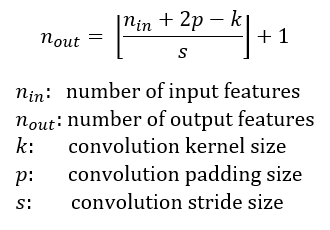

- p는 통상 1이라고 보면 됨

In [ ]:
# Generator
def Generator():
  inputs = tf.keras.layers.Input(shape = [256, 256, 3])
  # norm = tf.keras.layers.experimental.preprocessing.Rescaling(1. / 127.5, offset = -1)

  down_stack = [
                #커널 사이즈가 4인 건 feature map size가 2로 나뉘는 걸 유지하기 위함이라고 보면 됨
                downsample(64, 4, apply_instancenorm = False), # bs, 128, 128, 64
                downsample(128, 4), # 64, 64, 128
                downsample(256, 4), # 32, 32, 256
                downsample(512, 4), # 16, 16, 512
                downsample(512, 4), # 8, 8, 512
                downsample(512, 4), # 4, 4, 512
                downsample(512, 4), # 2, 2, 512
                downsample(512, 4)  # 1, 1, 512
                ]
  
  up_stack = [
              upsample(512, 4, apply_dropout = True), # Skip Connection으로 이어줄 거임 : bs, 2, 2, 1024
              upsample(512, 4, apply_dropout = True), # bs, 4, 4, 1024
              upsample(512, 4, apply_dropout = True), # bs, 8, 8, 1024
              upsample(512, 4,), # bs, 16, 16, 1024
              upsample(256, 4,), # bs, 32, 32, 512
              upsample(128, 4,), # bs, 64, 64, 256
              upsample(64, 4,), # bs, 128, 128, 128
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(3, # OUTPUT CHANNELS - RGB
                                        4,
                                        strides = 2,
                                        padding = 'same',
                                        kernel_initializer = initializer,
                                        activation = 'tanh') # bs, 256, 256, 3

  x = inputs
  # x = norm(x) # 이미지 전처리 : [-1, 1]
  skips = []

  for down in down_stack:
    x = down(x) 
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs = inputs, outputs = x)

In [ ]:
# Discriminator
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)
  gamma_init = keras.initializers.RandomNormal(mean =0.0, stddev = 0.02)

  input = keras.layers.Input(shape = [256, 256, 3], name = 'input_img')

  x = input # 얘는 정규화할 필요 없다~

  down1 = downsample(64, 4, False)(x) # bs, 128, 128, 64
  down2 = downsample(128, 4)(down1) # bs, 64, 64, 128
  down3 = downsample(256, 4)(down2) # bs, 32, 32, 256

  zero_pad1 = keras.layers.ZeroPadding2D()(down3) # bs, 34, 34, 256
  conv = keras.layers.Conv2D(512, 4, strides = 1,
                       kernel_initializer = initializer,
                       use_bias = False)(zero_pad1) # bs, 31, 31, 512 
  norm1 = tfa.layers.InstanceNormalization(gamma_initializer = gamma_init)(conv)
  leaky_relu = keras.layers.LeakyReLU()(norm1)
  
  zero_pad2 = keras.layers.ZeroPadding2D()(leaky_relu) # bs, 33, 33, 512
  last = keras.layers.Conv2D(1, 4, strides = 1,
                       kernel_initializer = initializer)(zero_pad2) # bs, 30, 30, 1
  
  return tf.keras.Model(inputs = input, outputs = last)

In [ ]:
# # TPU 돌리는 건가봄
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#   print("Device : ", tpu.master())
#   tf.config.experimental_connect_to_cluster(tpu)
#   tf.tpu.expermental.initializer_tpu_system(tpu)
#   strategy = tf.distribute.experimental.TPUStrategy()
# except:
#   strategy = tf.distribute.get_strategy()
# print("Number of Replicas : ", strategy.num_replicas_in_sync)

In [ ]:
# Generator와 Discriminator의 구조는 동일한데 들어가는 데이터만 다름

paint_generator = Generator() # 그림을 입력으로 받는 Generator1
photo_generator = Generator() # 사진을 입력으로 받는 Generator2

paint_discriminator = Discriminator() # 진짜 그림 vs 생성된 그림 구분하는 구별기1
photo_discriminator = Discriminator() # 진짜 사진 vs 생성된 사진 구분하는 구별기2

In [ ]:
paint_ex = next(iter(paint_ds)) # File system scheme '[local]' not implemented (file: 'monet_jpg/aa76c7625a.jpg') 
                                # TPU 쓸 때는 tf.io가 아니라 read로 읽으라고 하네요!
photo_ex = next(iter(photo_ds))

UnimplementedError: ignored

In [ ]:
to_paint = paint_generator(paint_ex)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


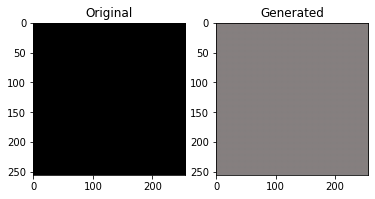

In [ ]:
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(paint_ex[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title('Generated')
plt.imshow(to_paint[0] * 0.5 + 0.5 )
plt.show()

In [ ]:
paint_ds = paint_ds.map(lambda x: x / 127.5 - 1)
photo_ds = photo_ds.map(lambda x: x / 127.5 - 1)

paint_ds = paint_ds.prefetch(tf.data.experimental.AUTOTUNE)
photo_ds = photo_ds.prefetch(tf.data.experimental.AUTOTUNE)

## CycleGan 빌드

In [ ]:
class CycleGan(tf.keras.Model):
  def __init__(self, paint_generator, photo_generator, paint_discriminator, photo_discriminator, lambda_cycle = 10):
    super(CycleGan, self).__init__()
    self.m_gen = paint_generator
    self.p_gen = photo_generator
    self.m_disc = paint_discriminator
    self.p_disc = photo_discriminator
    self.lambda_cycle = lambda_cycle

  def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, 
              gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
    super(CycleGan, self).compile()
    self.m_gen_optimizer = m_gen_optimizer
    self.p_gen_optimizer = p_gen_optimizer
    self.m_disc_optimizer = m_disc_optimizer
    self.p_disc_optimizer = p_disc_optimizer
    self.gen_loss_fn = gen_loss_fn
    self.disc_loss_fn = disc_loss_fn
    self.cycle_loss_fn = cycle_loss_fn
    self.identity_loss_fn = identity_loss_fn

  def train_step(self, batch_data):
    real_paint, real_photo = batch_data

    with tf.GradientTape(persistent = True) as tape:
      fake_paint = self.m_gen(real_photo, training = True)
      cycled_photo = self.p_gen(fake_paint, training = True)

      fake_photo = self.p_gen(real_paint, training = True)
      cycled_paint = self.m_gen(fake_photo, training = True)

      same_paint = self.m_gen(real_paint, training = True)
      same_photo = self.p_gen(real_photo, training = True)

      disc_real_paint = self.m_disc(fake_paint, training = True)
      disc_real_photo = self.p_disc(real_photo, training = True)

      disc_fake_paint = self.m_disc(fake_paint, training = True)
      disc_fake_photo = self.p_disc(fake_photo, training = True)

      paint_gen_loss = self.gen_loss_fn(disc_fake_paint)
      photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

      total_cycle_loss = self.cycle_loss_fn(real_paint, same_paint, self.lambda_cycle) + self.cycle_loss_fn(real_photo, same_photo, self.lambda_cycle)
     
      total_paint_gen_loss = paint_gen_loss + total_cycle_loss + self.identity_loss_fn(real_paint, same_paint, self.lambda_cycle)
      total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

      paint_disc_loss = self.disc_loss_fn(disc_real_paint, disc_fake_paint)
      photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

    paint_generator_gradients = tape.gradient(total_paint_gen_loss, self.m_gen.trainable_variables)
    photo_generator_gradients = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
      
    paint_discriminator_gradients = tape.gradient(paint_disc_loss, self.m_disc.trainable_variables)
    photo_discriminator_gradients = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

    self.m_gen_optimizer.apply_gradients(zip(paint_generator_gradients, self.m_gen.trainable_variables))
    self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients, self.p_gen.trainable_variables))

    self.m_disc_optimizer.apply_gradients(zip(paint_discriminator_gradients, self.m_disc.trainable_variables))
    self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients, self.p_disc.trainable_variables))

    return {
        "paint_gen_loss" : total_paint_gen_loss,
        "photo_gen_loss" : total_photo_gen_loss,
        "paint_disc_loss" : paint_disc_loss,
        "photo_disc_loss" : photo_disc_loss
    }

## 손실함수 정의
- D : 진짜는 1로 이루어진 크로스 엔트로피 행렬, 가짜는 0으로 이루어진 크로스 엔트로피 행렬과 연산
- G : 생성된 이미지와 1로 이루어진 크로스엔트로피 행렬
- Cycle_Loss : A->B->A' 로 돌아왔을 때 A'와 A의 차이
- Identity Loss : G에 들어간 Input 이미지와 Output 이미지 간 차이 

In [ ]:
def discriminator_loss(real, generated):
  real_loss = tf.keras.losses.BinaryCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)
  generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5 # 손실의 평균을 낸다

In [ ]:
def generator_loss(generated):
  return tf.keras.losses.BinaryCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image, LAMBDA):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

# 훈련

In [ ]:
paint_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

paint_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [ ]:
cycle_gan_model = CycleGan(
    paint_generator, photo_generator, paint_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = paint_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = paint_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [ ]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((paint_ds, photo_ds)),
    epochs = 25
)

Epoch 1/25
 4/10 [===========>..................] - ETA: 18:46 - paint_gen_loss: 25.7722 - photo_gen_loss: 25.6745 - paint_disc_loss: 0.6931 - photo_disc_loss: 0.6926

In [ ]:
# Visualization
_, ax = plt.subplots(5, 2, figsize = (12, 12))
for i, img in enumerate(photo_ds.take(5)):
  prediction = paint_generator(img, training = False)[0].numpy()
  prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
  img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

  ax[i, 0].imshow(img)
  ax[i, 1].imshow(prediction)
  ax[i, 0].set_title("Input Photo")
  ax[i, 1].set_title('Paint Like Photo')
  ax[i, 0].axis('off')
  ax[i, 1].axis('off')
plt.show()

NameError: ignored

In [ ]:
P